# Imports

In [1]:
import torch
import torch.nn as nn # all nn modules
import torch.optim as optim # optimization algorithms
import torch.nn.functional as F # activation functions like relu, tanh (all functions with no parameters)
from torch.utils.data import DataLoader # helps with data
import torchvision.datasets as datasets # has many data sets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from torch.utils.tensorboard import SummaryWriter

# Hyperparameters

In [2]:
input_size = 784
num_classes = 10
learning_rate = 0.001
# how many data examples we pass in one iteration
batch_size = 64
epochs = 3

# Load dataset

In [3]:
train_data = datasets.MNIST(root = "data/", train=True, transform=transforms.ToTensor())
# We pass the Dataset as an argument to DataLoader
# This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading
# Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels
train_loader = DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True)

In [4]:
test_data = datasets.MNIST(root = "data/", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_data, batch_size = batch_size, shuffle=True)

In [5]:
for X, y in train_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [6]:
# for iteration we use loaded data
for data in train_loader: 
    # 64 digits and 64 labels
    print(data)
    break    

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [7]:
x, y = data[0][0], data[1][0]

In [8]:
# print(x)

In [9]:
# print(y)

# Find unique labels in the dataset

In [10]:
unique_labels = set()
for element in data[1].numpy():
    unique_labels.add(element)
print(unique_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


You can see some of the images in the dataset by running the following cell.

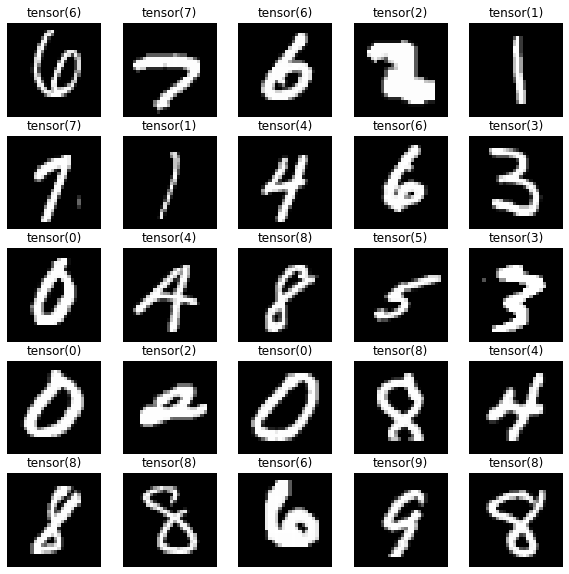

In [11]:
# plt.imshow(data[0][0])
# (1, 28, 28) so plt.imshow() wont work
# so use .view(28, 28)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(data[0][i].view(28,28),cmap='Greys_r')
    plt.title(data[1][i])
    plt.axis("off")

# To find whether the classes are balanced or not

In [12]:
total = 0
counter_dict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}

for data in train_loader:
    Xs, ys =  data
    for y in ys:
        # increase the count of corresponding class by 1
        counter_dict[int(y)] +=1
        total +=1
print(counter_dict)

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


# We can see the classes are well balanced

In [29]:
for i in counter_dict:
    # percentages of class in the dataet
    print(f"{i}: {counter_dict[i]/total*100:.3f}")

0: 9.872
1: 11.237
2: 9.930
3: 10.218
4: 9.737
5: 9.035
6: 9.863
7: 10.442
8: 9.752
9: 9.915


# Create a fully connected NN

In [14]:
# inherits from the nn module
# Our first linear layer take input_size, in this case 784 nodes to 512
# and our second linear layer takes 512 to the num_classes we have, in this case 10.
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        # input layer
        # fc1 = fully connected layer 1
        self.fc1 = nn.Linear(input_size, 512)
        # self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
        self.initialize_weights()
    
    # create a forward function
    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                nn.init.constant_(m.bias, 0)
                

In [15]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
# 28*28 images passes as 784
# 10 for no of digits
model = NN(784, 10)
# 64 = no of examples (images) mini batch size
x = torch.rand((64, 784))
model(x).shape

torch.Size([64, 10])

# Initialize the network

In [17]:
model = NN(input_size = input_size, num_classes = num_classes).to(device)

# Loss & optimizer

In [18]:
# loss- how wrong our model is
loss_fn = nn.CrossEntropyLoss()
# optimizer- adjusts the weights to decrese the loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# if loss does not decrease on 5 iters, we decrease the learning rate
scheduler =optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=5, verbose=True)

# Tensorboard for data visualization

In [19]:
writer = SummaryWriter(f'runs/MNIST/trying_tensorboard')

# Train the network

In [20]:
def train(dataloader, model, loss_fn, optimizer, step):
    size = len(dataloader.dataset)
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # X has shape (64, 1, 28, 28)
        # 64 training examples
        # 1 as we are using gray scale images
        # 28 * 28 height, width        
        # we need to reshape this to (64, 784)
        
        X = X.reshape(X.shape[0],-1)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        losses.append(loss.item())

        # Backpropagation
        # set gradients to zero for each batch, so it does not store back prop calculation from previous forward props
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient step
        optimizer.step()
        
        # calculate running training accuracy
        _, predictions = pred.max(1)
        num_correct = (predictions==y).sum()
        running_train_accuracy = float(num_correct)/float(X.shape[0])
        
        writer.add_scalar('Training loss', loss, global_step=step)
        writer.add_scalar('Training accuracy',running_train_accuracy, global_step=step)
        step+=1
        

        if batch % 100 == 0:
            # print(f"batch: {batch}, len:{len(X)}, current: {batch*len(X)}")
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return losses

In [21]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    
    num_batches = len(dataloader)
    
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.reshape(X.shape[0],-1)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    step = 0
    loss = train(train_loader, model, loss_fn, optimizer, step)
    test(test_loader, model, loss_fn)
    mean_loss = sum(loss)/len(loss)
    scheduler.step(mean_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.338643  [    0/60000]
loss: 0.298973  [ 6400/60000]
loss: 0.322257  [12800/60000]
loss: 0.153560  [19200/60000]
loss: 0.204788  [25600/60000]
loss: 0.460018  [32000/60000]
loss: 0.116017  [38400/60000]
loss: 0.126144  [44800/60000]
loss: 0.110962  [51200/60000]
loss: 0.086048  [57600/60000]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.120183 

Epoch 2
-------------------------------
loss: 0.131606  [    0/60000]
loss: 0.144656  [ 6400/60000]
loss: 0.109439  [12800/60000]
loss: 0.077835  [19200/60000]
loss: 0.037775  [25600/60000]
loss: 0.148562  [32000/60000]
loss: 0.050184  [38400/60000]
loss: 0.083327  [44800/60000]
loss: 0.040653  [51200/60000]
loss: 0.037164  [57600/60000]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.081727 

Epoch 3
-------------------------------
loss: 0.037899  [    0/60000]
loss: 0.059639  [ 6400/60000]
loss: 0.024261  [12800/60000]
loss: 0.010164  [19200/60000]
loss: 0.126879  [25600/60000]
loss: 0.034017  [32000/600

# Check some predictions from testset

In [23]:
for data in test_loader:
    X, y = data
    break

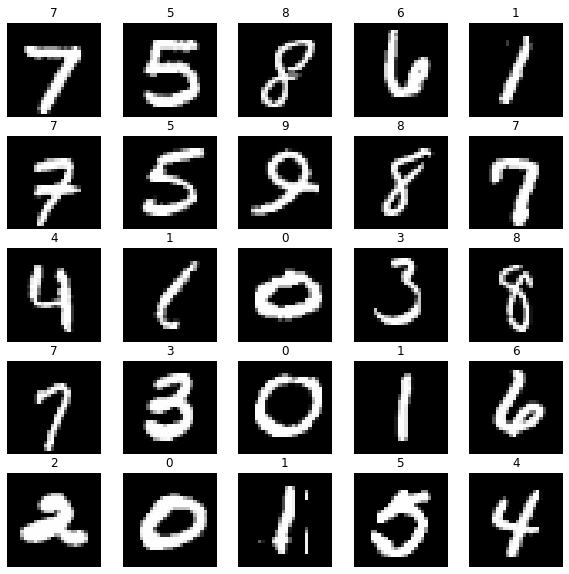

In [30]:
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(X[i].view(28,28),cmap='Greys_r')
    plt.title(y[i].numpy())
    plt.axis("off")